In [7]:
#Import dependency
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import requests
import psycopg2
import config as creds


In [59]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [60]:
# Connecting to DB

conn, cursor = connect()

# SQL command to create inventory table
sql = "select * from ames;"
#cursor.execute(sql)
df = pd.read_sql_query(sql, conn)
#conn.commit()
# dat = pd.read_sql_query(sql, conn)


**Final Data Cleaning before importing the dataset into our model**

In [61]:
#Drop the ames_order, pid column since it doesn't help with prediction
df.drop(columns=["ames_order","pid"], axis=1, inplace=True)
df

,mssubclass,mszoning,lotarea,street,lotshape,landcontour,lotconfig,landslope,neighborhood,condition1,...,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,20,RL,31770,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,0,0,0,0,5,2010,WD,Normal,215000,4920
1,20,RH,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,0,120,0,0,6,2010,WD,Normal,105000,3404
2,20,RL,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,0,0,0,12500,6,2010,WD,Normal,172000,4299
3,20,RL,11160,Pave,Reg,Lvl,Corner,Gtl,NAmes,Norm,...,0,0,0,0,4,2010,WD,Normal,244000,6852
4,60,RL,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,0,0,0,0,3,2010,WD,Normal,189900,4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,7937,Pave,IR1,Lvl,CulDSac,Gtl,Mitchel,Norm,...,0,0,0,0,3,2006,WD,Normal,142500,3597
2926,20,RL,8885,Pave,IR1,Low,Inside,Mod,Mitchel,Norm,...,0,0,0,0,6,2006,WD,Normal,131000,3152
2927,85,RL,10441,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,...,0,0,0,700,7,2006,WD,Normal,132000,2852
2928,20,RL,10010,Pave,Reg,Lvl,Inside,Mod,Mitchel,Norm,...,0,0,0,0,4,2006,WD,Normal,170000,4585


In [63]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'saletype',
       'salecondition'],
      dtype='object')

In [64]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice', 'total_area'],
      dtype='object')

**check histogram and see if they are normally distributed in order to be used in linear regression model --> transform the skewed numeric features by taking log(feature + 1) -->make features more normally distributed**

In [65]:
#Check skewness of the dataset
from scipy.stats import skew 
skewness = numerical.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

miscval          21.988523
poolarea         16.930469
lotarea          12.814334
lowqualfinsf     12.111957
3ssnporch        11.397956
kitchenabvgr      4.311616
bsmtfinsf2        4.138674
enclosedporch     4.012390
screenporch       3.955441
bsmthalfbath      3.940371
masvnrarea        2.617964
openporchsf       2.534088
wooddecksf        1.841735
saleprice         1.742607
1stflrsf          1.468676
bsmtfinsf1        1.415696
total_area        1.319018
grlivarea         1.273457
totalbsmtsf       1.150257
bsmtunfsf         0.922572
2ndflrsf          0.866013
totrmsabvgrd      0.753157
fireplaces        0.738837
halfbath          0.697356
bsmtfullbath      0.617411
bedroomabvgr      0.305538
garagearea        0.239942
mosold            0.192497
fullbath          0.171864
yrsold            0.134793
garagecars       -0.221049
yearremodadd     -0.451631
yearbuilt        -0.604153
garageyrblt      -3.914938
dtype: float64

In [66]:
#normalize the data by taking log
skewness = np.log(skewness)
skewness.sort_values(ascending=False)

C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


miscval          3.090521
poolarea         2.829115
lotarea          2.550564
lowqualfinsf     2.494193
3ssnporch        2.433434
kitchenabvgr     1.461313
bsmtfinsf2       1.420375
enclosedporch    1.389387
screenporch      1.375092
bsmthalfbath     1.371275
masvnrarea       0.962397
openporchsf      0.929834
wooddecksf       0.610708
saleprice        0.555382
1stflrsf         0.384361
bsmtfinsf1       0.347621
total_area       0.276888
grlivarea        0.241736
totalbsmtsf      0.139985
bsmtunfsf       -0.080589
2ndflrsf        -0.143855
totrmsabvgrd    -0.283482
fireplaces      -0.302678
halfbath        -0.360459
bsmtfullbath    -0.482220
bedroomabvgr    -1.185682
garagearea      -1.427359
mosold          -1.647672
fullbath        -1.761052
yrsold          -2.004012
yearbuilt             NaN
yearremodadd          NaN
garageyrblt           NaN
garagecars            NaN
dtype: float64

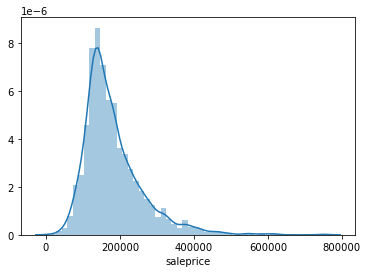

In [67]:
# check if saleprice is normally distributed in order to be used in our Multiple linear regression model later
sns.distplot(df['saleprice']);
#we can see the saleprice is right skewed

# transform the the saleprice by taking log to make the data more normally distribute
df['saleprice'] = np.log1p(df['saleprice'])

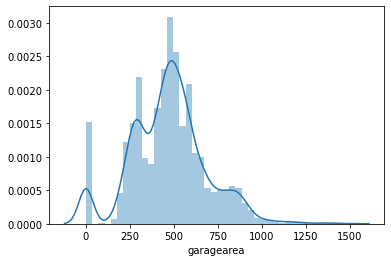

In [68]:
#check the distribution of garagearea
sns.distplot(df['garagearea']);

In [69]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

mssubclass       0
mszoning         0
lotarea          0
street           0
lotshape         0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 65, dtype: int64

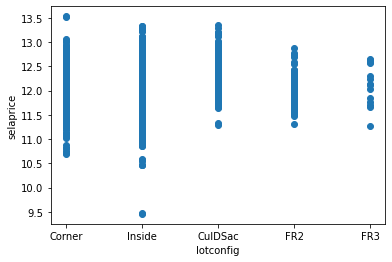

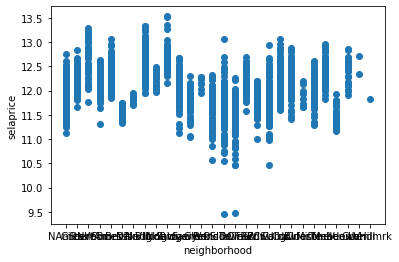

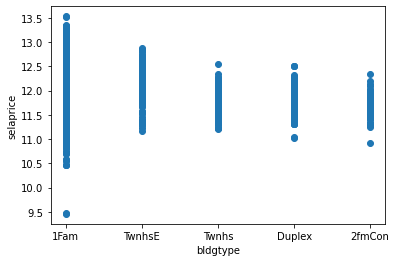

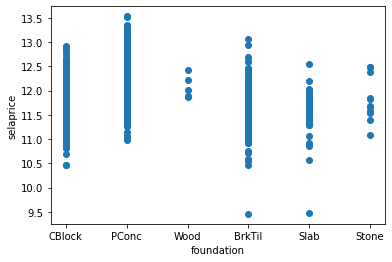

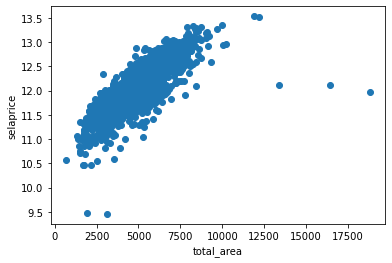

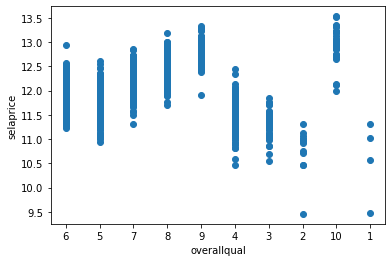

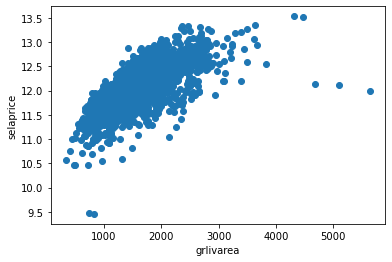

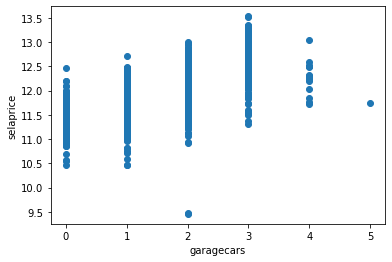

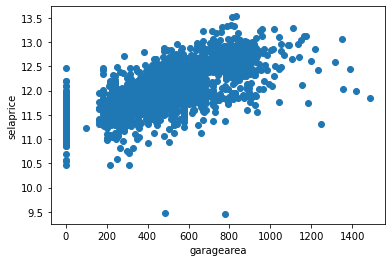

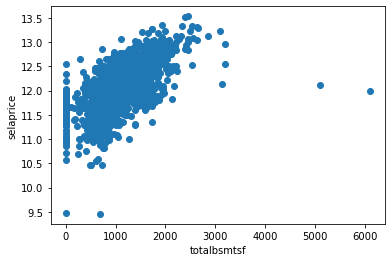

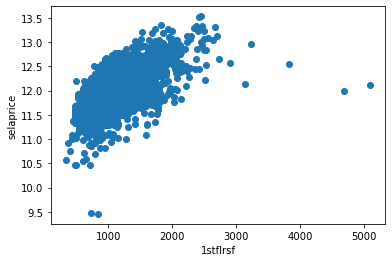

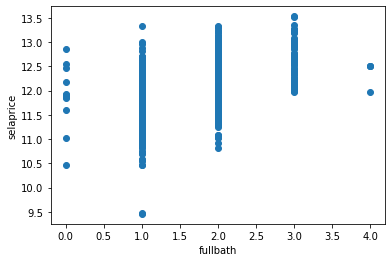

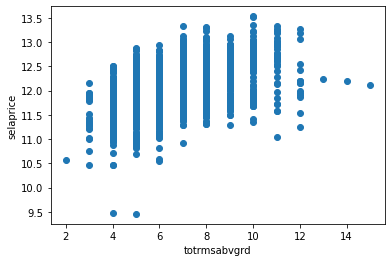

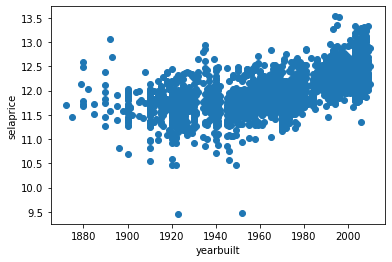

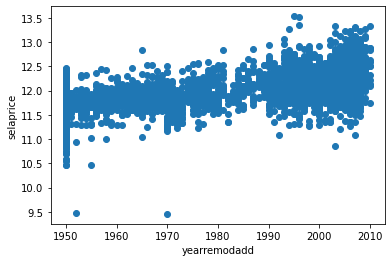

In [70]:
#See the relationship between selected features and target
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

# **Initial Features Selection**
we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5). We also added another additional features: total_area

* overallqual
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd
* ADDED total_area

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* lotconfig
* neighborhood
* bldgtype
* foundation


In [71]:
#Determine features and target
feature = df.drop(columns=['saleprice'])
target = df['saleprice']

print(feature)
print(target)

     mssubclass mszoning  lotarea street lotshape landcontour lotconfig  \
0            20       RL    31770   Pave      IR1         Lvl    Corner   
1            20       RH    11622   Pave      Reg         Lvl    Inside   
2            20       RL    14267   Pave      IR1         Lvl    Corner   
3            20       RL    11160   Pave      Reg         Lvl    Corner   
4            60       RL    13830   Pave      IR1         Lvl    Inside   
...         ...      ...      ...    ...      ...         ...       ...   
2925         80       RL     7937   Pave      IR1         Lvl   CulDSac   
2926         20       RL     8885   Pave      IR1         Low    Inside   
2927         85       RL    10441   Pave      Reg         Lvl    Inside   
2928         20       RL    10010   Pave      Reg         Lvl    Inside   
2929         60       RL     9627   Pave      Reg         Lvl    Inside   

     landslope neighborhood condition1  ... enclosedporch 3ssnporch  \
0          Gtl        NAmes 

**Use Label Encoder to to transform categorical features**

In [72]:
#Convert numerical categories that shouldn't be numerical to categorical categories
#please refer to the description file for definition of each category
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond'] = df['overallcond'].astype(str)
df['overallqual'] = df['overallqual'].astype(str)
df.dtypes

mssubclass        object
mszoning          object
lotarea            int64
street            object
lotshape          object
                  ...   
yrsold            object
saletype          object
salecondition     object
saleprice        float64
total_area         int64
Length: 65, dtype: object

In [76]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ('mssubclass', 'mszoning', 'street', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'paveddrive', 'mosold',
       'yrsold', 'saletype', 'salecondition')

for col in cols:
  le = LabelEncoder()
  le.fit(list(df[col].values))
  df[col] = le.fit_transform(list(df[col].values))
df.shape  

(2930, 65)

# **Step 4: Multiple Linear Regression Model: Predict house prices based on the selected features**
* Set x and y
* Scale x and y
* Split the data into train and test (X:features, y=target)
* Create an instance of the model with model = LinearRegression().
* Train the model with the dataset with model.fit(X,y)
* Create predictions with y_pred = model.predict(X)


In [207]:
#put our selected features into a list

cols = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","totrmsabvgrd", "yearbuilt","yearremodadd"]
#try using only the numerical category
#cols = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

#take away the "grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath" that were used to calculaye "total area"

#assign y to our target and x to our features 
y = df['saleprice'].values
X = df[cols]

#try using all the columns as features
# X = df.loc[:, df.columns != 'saleprice']

#scale the data
X_scaled = preprocessing.StandardScaler().fit_transform(X)
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))


Perform 80/20 data split

In [208]:
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2344, 9), (586, 9), (2344, 1), (586, 1))

**Fit data to our Multiple Linear Regression Model**

In [209]:
#define the model
model = linear_model.LinearRegression()
#build training model --> time start time 
start=datetime.now()
model.fit(X_train, y_train)

#time the end time
end=datetime.now()

#run prediction on test set 
y_test_pred = model.predict(X_test)


In [210]:
#print the coefficient, intercept, MSE and model score(R^2),and model run time
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared Error(MSE): {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Coefficient of Determination(R^2): {r2_score(y_test, y_test_pred):.2f}")
time_taken = end - start
print(f"Time to run the model: {time_taken}")


Coefficients: [[-0.00238714  0.0152481  -0.07379042 -0.00923208  0.63430507  0.22047439
  -0.07609687  0.20582983  0.13510835]]
Intercept: [0.00192568]
Mean squared Error(MSE): 0.20
Coefficient of Determination(R^2): 0.80
Time to run the model: 0:00:00.002263


In [211]:
def formulation(b,cols):
    
    cols = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
    b = [0.44732537,0.21944313,0.08801812,0.13320604,-0.04323234,0.04047272,0.05245853,-0.05247924,-0.03586293,0.16607648,0.14366576]

    for i in (b, cols):
        y = 0.00268281 +
    return y
print(y)

y = 0.0026828 + 0.44732537*total_area + 0.21944313*overallqual + 0.08801812*grlivarea + 0.13320604*garagecars + (-0.04323234*garagearea) + 0.04047272*totalbsmtsf +0.05245853*1stflrsf +(-0.05247924*fullbath)+(-0.03586293*totrmsabvgrd)+ 0.16607648*yearbuilt +0.14366576* yearremodadd  

SyntaxError: invalid syntax (<ipython-input-211-20af437154cc>, line 7)

In [212]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
nn_model.summary()
nn_model.compile(loss="mean_squared_error", optimizer="adam")
#time starting time
start_1=datetime.now()
nn_model.fit(X_train_scaled, np.asarray(y_train), epochs=100)
#time ending time
end_1=datetime.now()

y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)

deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu"))
deep_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
deep_model.summary()

deep_model.compile(loss="mean_squared_error", optimizer="adam")
#start deep learning starting time
start_2=datetime.now()
deep_model.fit(X_train_scaled, np.asarray(y_train), epochs=100)
#time deep learning ending time
end_2=datetime.now()
y_train_pred = deep_model.predict(X_train_scaled)
y_test_pred = deep_model.predict(X_test_scaled)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 18)                180       
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 19        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2344/2344 [==============================] - 1s 321us/sample - loss: 0.8646
Epoch 2/100
2344/2344 [==============================] - 0s 33us/sample - loss: 0.7171
Epoch 3/100
2344/2344 [==============================] - 0s 34us/sample - loss: 0.6225
Epoch 4/100
2344/2344 [==============================] - 0s 30us/sample - loss: 0.5583
Epoch 5/100
2344/2344 [==============================] - 0s 32us/sample - loss: 0.5036
Epoch 6/100
2344/2344 [==============================] - 0s 30us/sample - loss: 0

Epoch 87/100
2344/2344 [==============================] - 0s 31us/sample - loss: 0.1514
Epoch 88/100
2344/2344 [==============================] - 0s 29us/sample - loss: 0.1525
Epoch 89/100
2344/2344 [==============================] - 0s 29us/sample - loss: 0.1511
Epoch 90/100
2344/2344 [==============================] - 0s 27us/sample - loss: 0.1517
Epoch 91/100
2344/2344 [==============================] - 0s 30us/sample - loss: 0.1503
Epoch 92/100
2344/2344 [==============================] - 0s 29us/sample - loss: 0.1509
Epoch 93/100
2344/2344 [==============================] - 0s 28us/sample - loss: 0.1500
Epoch 94/100
2344/2344 [==============================] - 0s 29us/sample - loss: 0.1504
Epoch 95/100
2344/2344 [==============================] - 0s 28us/sample - loss: 0.1502
Epoch 96/100
2344/2344 [==============================] - 0s 28us/sample - loss: 0.1507
Epoch 97/100
2344/2344 [==============================] - 0s 30us/sample - loss: 0.1493
Epoch 98/100
2344/2344 [========

In [213]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))
time_taken_neu = end_1 - start_1
print(time_taken_neu)

time_taken_dl = end_2 - start_2
print(time_taken_dl)

0.8581854941439736
0.841538133123216
0:00:08.138578
0:00:08.550226


C:\Users\chiko\anaconda3\envs\PythonData\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


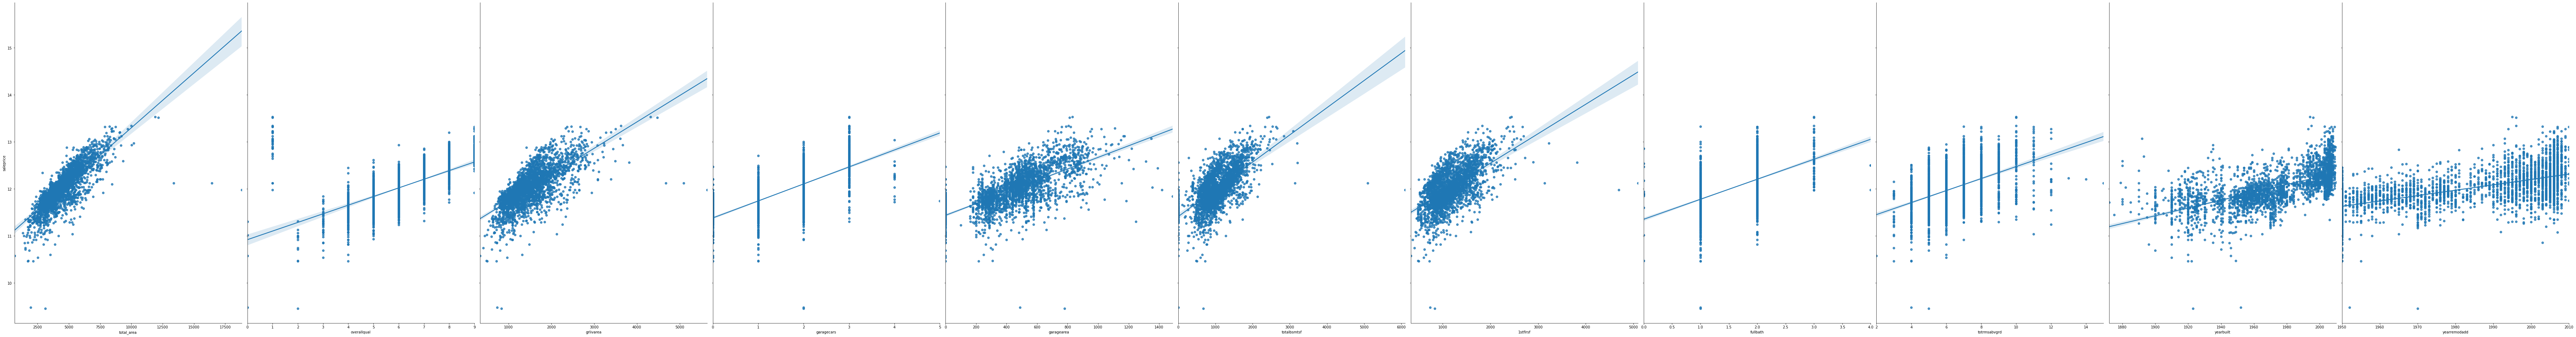

In [215]:
sns.pairplot(df, x_vars=["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"], y_vars='saleprice', size=13, aspect=0.7, kind='reg')


# Models Comparison


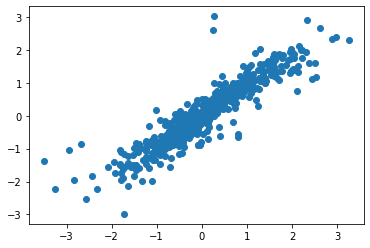

In [214]:

plt.scatter(y_test, y_test_pred)
plt.show()


**Comparing Multiple Linear Regression VS Deep Learning in terms of model running time**

In [41]:

MLR = [
]
DL = [0.0023, 16.68]
data_dict = {'Model': pd.Series(Model), 'Run Time':pd.Series(Time)}

df2 = pd.DataFrame(data_dict)
df2

,Model,Run Time
0,MLR,0.0279
1,DL,13.8600


<BarContainer object of 2 artists>

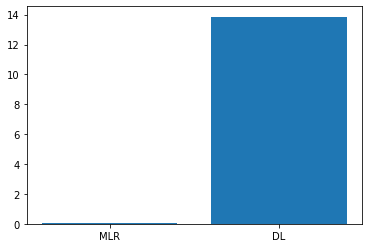

In [42]:
Features = ["11", "15", "79"]
x = ['MLR', 'DL']
y = [0.0279, 13.86]
plt.bar(x,y)

**Comparing Multiple Linear Regression VS Deep Learning in terms of R^2**

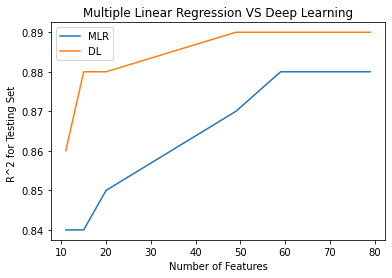

In [43]:
x = [11, 15, 20, 49, 59, 79]
MLR = [0.84, 0.84, 0.85, 0.87, 0.88, 0.88]
DL = [0.89,0.83,0.81,0.83,0.81,0.85,0.85,0.84]
fig, ax = plt.subplots()
ax.plot(x,MLR, label='MLR')
ax.plot(x,DL, label='DL')
ax.set_title("Multiple Linear Regression VS Deep Learning")
ax.set_xlabel("Number of Features")
ax.set_ylabel("R^2 for Testing Set ")
ax.legend()

In [44]:
columns = [
    "Num_feat",
    "Model",
    "R^2",
    "Time"
]
rows = [
    (11, "MLR", 0.84, 0.0279),
    (11, "DL", 0.86, 6.86),
    (15, "MLR", 0.84, 0.00199),
    (15, "DL", 0.88, 7.12),
    (20, "MLR", 0.85, "NA"),
    (20, "DL", 0.88, "NA"),
    (49, "MLR", 0.87, "NA"),
    (49, "DL", 0.89, "NA"),
    (59, "MLR", 0.88, "NA"),
    (59, "DL", 0.89, "NA"),
    (79, "MLR", 0.88, "NA"),
    (79, "DL", 0.89, "NA")
]

In [45]:
model_info = pd.DataFrame(columns = columns, data=rows)
model_info.set_index("Num_feat", inplace=True)
model_info

,Model,R^2,Time
Num_feat,,,
11,MLR,0.84,0.0279
11,DL,0.86,6.86
15,MLR,0.84,0.00199
15,DL,0.88,7.12
20,MLR,0.85,NA
20,DL,0.88,NA
49,MLR,0.87,NA
49,DL,0.89,NA
59,MLR,0.88,NA


In [15]:
data = pd.read_csv('Resources/run_time_r2.csv')
data


,Features,MLR_R^2,MLR^Run_Time,DL_R^2,DL_Run_Time,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,64.0,0.83,0.0055,0.89,16.20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54.0,0.83,0.0040,0.83,16.65,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44.0,0.77,0.0040,0.81,16.13,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34.0,0.76,0.0030,0.83,16.38,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24.0,0.75,0.0020,0.81,15.87,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15.0,0.80,0.0020,0.85,16.47,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11.0,0.79,0.0020,0.85,16.69,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9.0,0.80,0.0023,0.84,16.68,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
